### IN THIS NOTEBOOK WE DO INSERTION EXPERIMENTS

In [1]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

import akita_utils
import pysam
import h5py
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use


#base_dir = '/project/fudenber_735/backup/DNN_HiC/human-mouse_5-16-21/'
#model_dir = base_dir+"/f"+str(model_num)+"_c0/train/"

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'


# model_dir = '/home1/fudenber/repositories/basenji/manuscripts/akita/'
# model_file = model_dir+'/model_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-11-17 16:56:31.289805: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


built
restored


(512, 130305, (130305,))

### importing background seqs

In [3]:
background_file = base_dir + '../analysis/background_seqs.fa'
background_seqs = []
with open(background_file,'r') as f:
  for line in f.readlines():
    if '>' in line: continue
    background_seqs.append(dna_io.dna_1hot(line.strip())) 


### creating tsv for the chosen motifs (strong and weak)

In output, the order is first are strong the weak follow

In [4]:
seq_coords_df = akita_utils.prepare_insertion_tsv(
    h5_dirs = '/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5',
    score_key = 'SCD',
    flank_pad = 60, #how much flanking sequence around the sites to include
    weak_thresh_pct = 1, # don't use sites weaker than this, might be artifacts
    weak_num = 2 ,
    strong_thresh_pct = 99, # don't use sites stronger than this, might be artifacts
    strong_num = 5 ,
    save_tsv=None, # optional filename to save a tsv
)


29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model7/scd.h5
29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model1/scd.h5
annotating each site with boundary-wide scores
filtering sites by overlap with rmsk
df prepared


### Generating positions where to insert the motifs created in the previous step

In [5]:
s = seq_coords_df.iloc[0]
seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
insert_length = len(seq_1hot_motif)
spacer_bp = 120000
num_inserts = 6
multi_insert_length = num_inserts * (insert_length+spacer_bp)

offsets = []
for i in range(num_inserts):
    offsets.append( seq_length//2 - multi_insert_length//2 + i * (insert_length+spacer_bp))
offsets, seq_length//2

([294943, 415082, 535221, 655360, 775499, 895638], 655360)

### Each motif is inserted in the background to observe the resultant effect

In [24]:
all_inserts = {}
for s_num,s in enumerate(seq_coords_df.itertuples(index=False)):
    for background_seq_num, background_seq in enumerate(background_seqs):
        seq_1hot = background_seq.copy()
        seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
        if s.strand == '-': seq_1hot_motif = dna_io.hot1_rc(seq_1hot_motif)
        insert_length = len(seq_1hot_motif)
        for offset in offsets:
           seq_1hot[offset:offset+insert_length] = seq_1hot_motif
        all_inserts[s_num,background_seq_num] = seq_1hot  
    
# all_inserts   
# 

In [11]:
seq_coords_df

,index,chrom,start,end,strand,genomic_SCD
0,0,chr12,35192299,35192438,-,53.656250
1,1,chr8,102781052,102781191,-,53.500000
2,2,chr5,49961931,49962070,-,53.312500
3,3,chr9,26776296,26776435,-,53.125000
4,4,chr9,51152529,51152668,-,53.062500
5,0,chr7,139598251,139598390,+,0.058136
6,1,chr8,45342859,45342998,+,0.058319


In [29]:
## predict for each insertion

predictions=[]

for background_seq_num, background_seq in enumerate(background_seqs):
    custom_all_inserts=[]
    for i in range(len(seq_coords_df)):
        custom_all_inserts.append(all_inserts[i,background_seq_num])
    predictions.append(seqnn_model.predict(np.array(custom_all_inserts), batch_size=10))
    
    

### Visualization of the effect of each chosen motif in every available flat background

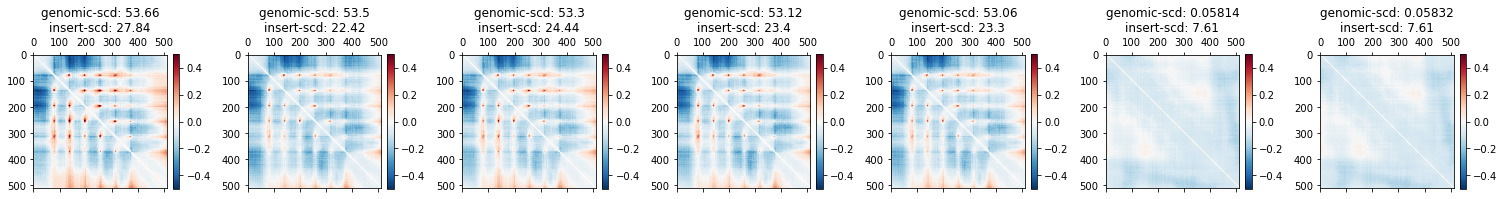

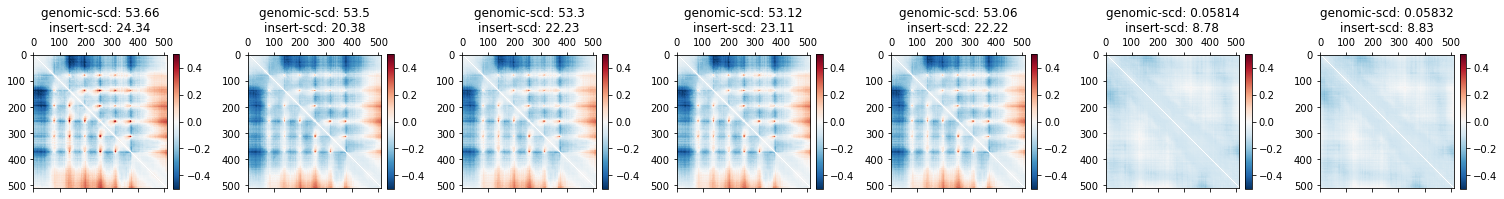

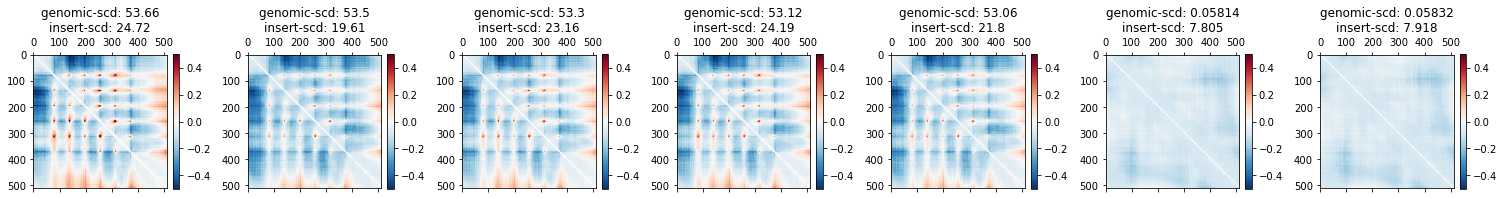

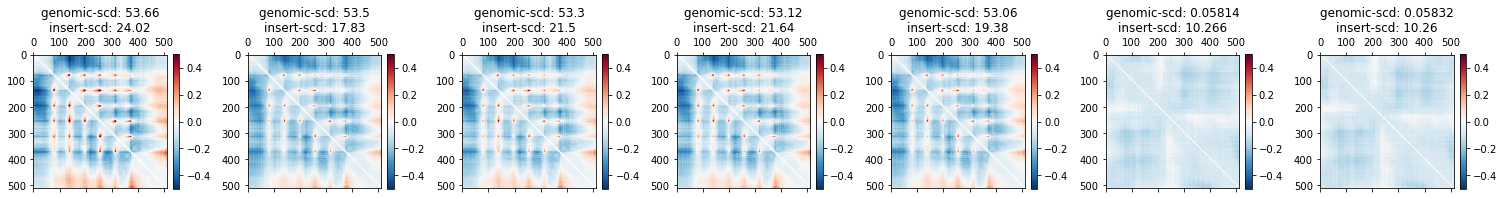

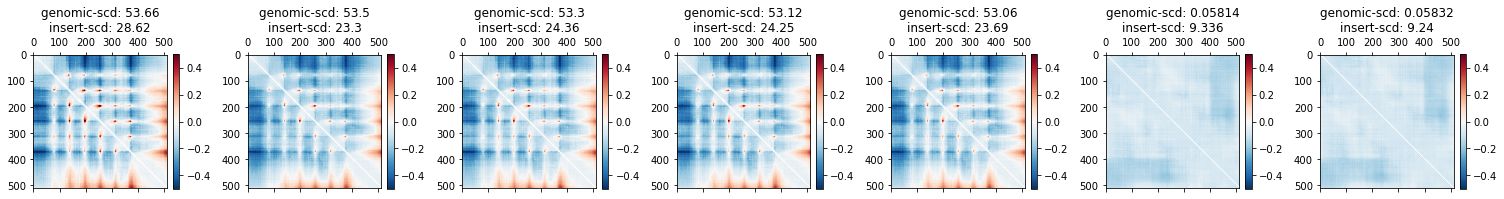

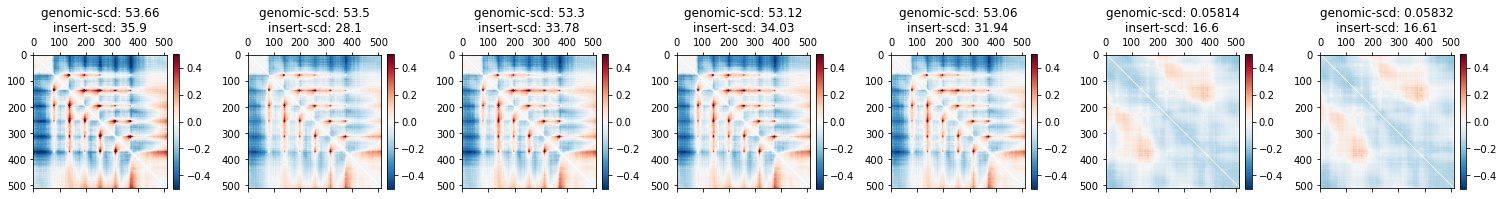

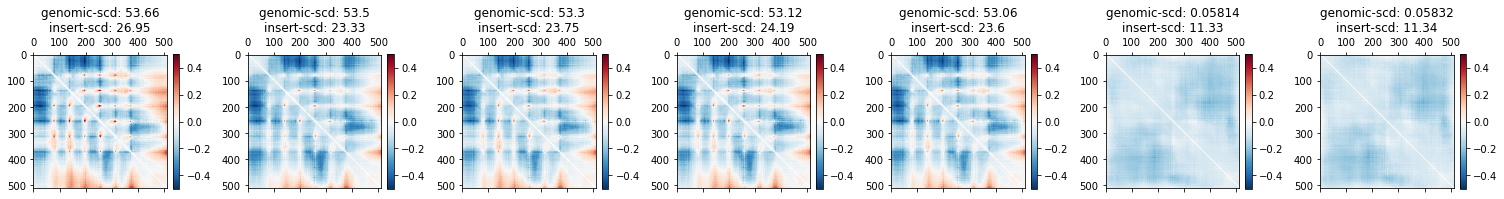

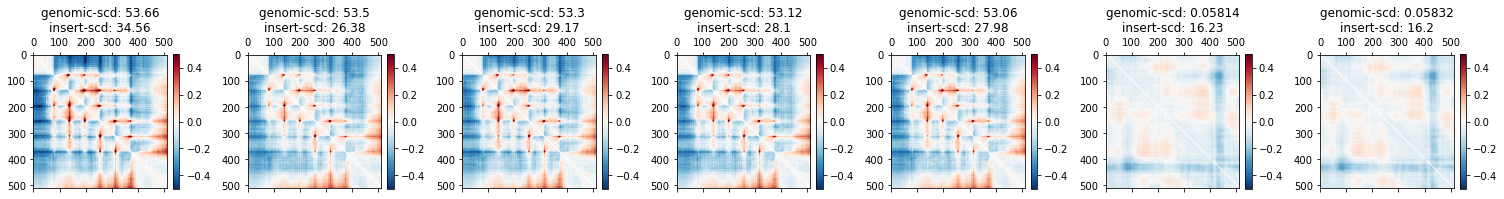

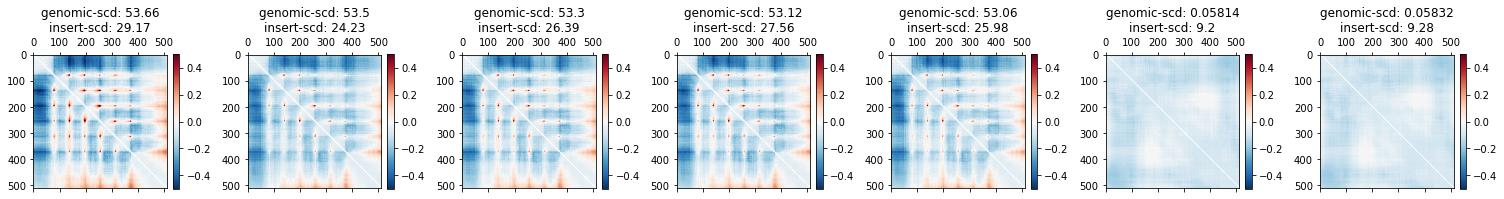

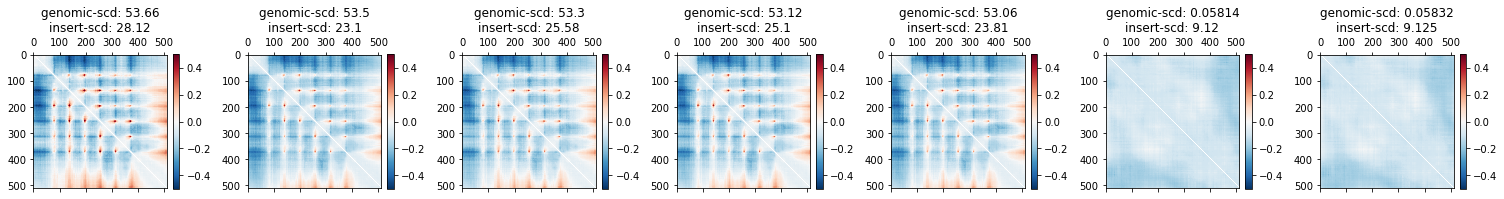

In [32]:
for background_seq_num, background_seq in enumerate(background_seqs):
    
    pred=predictions[background_seq_num]
    
    plt.figure(figsize=(len(seq_coords_df)*3,2*3))

    target_ind = 0
    vlim = .5
    bin_mid = target_map_size//2
    window = 100

    for i in range(len(seq_coords_df)):
        insert_pred = pred[i]
        # print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

        plt.subplot(2,len(seq_coords_df), i+1)
        im = plt.matshow(
                akita_utils.from_upper_triu(  
                insert_pred[:,target_ind], target_map_size,hic_diags),
                vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title('genomic-scd: '+str(seq_coords_df['genomic_SCD'].values[i]) +'\n'+
                  'insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
                  ) 
        #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
    plt.tight_layout()
    plt.show()